# Statistical Modelling of total contacts: model results

In [20]:
# # Adults
library(colorspace)
library(MASS)
library(glmmTMB)
library(dplyr)
library(ggplot2)
library(shape)
library(stringr)
library(RColorBrewer)
library(huxtable)
library(texreg)
library(tidyverse)
library(ggstats)
library(ggforce)
library(ggstance)
library(broom.mixed)
library(showtext)

font_add_google(name = "Barlow", family = "Barlow")
showtext_auto()


## Adult respondents

In [21]:
# ADULTS Models
adults_indirect_totcont <- readRDS("model_out/adults_indirect_totcont_glmmTMB.rds")
adults_indirect_ncohabcont <- readRDS("model_out/adults_indirect_ncohabcont_glmmTMB.rds")
adults_orig_totcont <- readRDS("model_out/adults_orig_totcont_glmmTMB.rds")
adults_soft_totcont <- readRDS("model_out/adults_soft_totcont_glmmTMB.rds")

In [22]:
### Get Fig1 MAIN Covariate groups' order
# Step 1: Tidy "adults_indirect_totcont" model
tidy_results <- tidy(adults_indirect_totcont, effects = 'fixed')
# Step 2: Extract the intercept
intercept <- tidy_results %>% filter(term == '(Intercept)') %>% pull(estimate)
intercept_exp <- exp(intercept)
# Step 3: Exponentiate and normalize estimates, excluding the intercept
z_std <- 1.96
tidy_results <- tidy_results %>%
  mutate(
    contacts_risk_ratio = ifelse(
      term != '(Intercept)',
      exp(estimate),  # Exponentiate and divide by intercept
      1  # Set intercept to 1
    ),
    # Step 4: Compute confidence intervals
    conf.low_ratio = ifelse(
      term != '(Intercept)',
      exp(estimate - z_std * std.error),
      exp(intercept - z_std * std.error) / intercept_exp
    ),
    conf.high_ratio = ifelse(
      term != '(Intercept)',
      exp(estimate + z_std * std.error),
      exp(intercept + z_std * std.error) / intercept_exp
    )
  )
# Step 4: attach covariate-group to each covariate
group_names <- c('Intercept',
    'Wave (ref: wave 2022)',
    'Sex (ref: male)',
    'Age (ref: 18-29 y/o)',
    'Age (ref: 18-29 y/o)',
    'Age (ref: 18-29 y/o)',
    'Age (ref: 18-29 y/o)',
    'Age (ref: 18-29 y/o)',
    'Education (ref: lower secondary or below)',
    'Education (ref: lower secondary or below)',
    'Occupation (ref: work)',
    'Occupation (ref: work)',
    'Occupation (ref: work)',
    'Occupation (ref: work)',
    'Income (ref: <1500€)',
    'Income (ref: <1500€)',
    'Income (ref: <1500€)',
    'Attendance (ref: remote or no attendance)',
    'Day (ref: weekday or Saturday)',
    'Vaccine cycle (ref: no)',
    'Recent SARS-CoV-2 infection (ref: no)',
    'Has chronic comorb. (ref: no)',
    'Cohabitant w/ comorb. (ref: no)',
    'Has senior cohabitant (ref: no)',
    'Has children (ref: no)',
    'Household size (ref: 1 member)',
    'Household size (ref: 1 member)',
    'Household size (ref: 1 member)',
    'Household size (ref: 1 member)'
)
tidy_results$group <- group_names

group_order <- tidy_results %>%
group_by(group) %>%
summarize(avg_abs_estimate = mean(abs(contacts_risk_ratio))) %>%
arrange(desc(avg_abs_estimate)) %>%
pull(group)
group_order <- c("Intercept",group_order[group_order != "Intercept"])


In [23]:
########################################################################################
# Function to generate a list of n colors by interpolating between the provided colors #
generate_palette <- function(input_colors, n, color_names) {
  if (length(input_colors)<2) {stop("At least two colors are required to interpolate.")}
  if (length(color_names) != n) {stop("Number of color names must match the desired number of colors.")}
  # Create a color ramp palette
  color_ramp <- colorRampPalette(input_colors)
  # Generate n colors
  palette_colors <- color_ramp(n)
  # Create a named vector
  named_palette <- setNames(palette_colors, color_names)
  return(named_palette)
}
########################################################
# Define the function to create the coefficient plot   #
# Function to create the coefficient plot from a model #
create_coefficient_plot <- function(model, group_order, group_names) {
    # Step 1: Tidy model and filter out zero-inflation component
    tidy_results <- tidy(model, effects = 'fixed') %>%
      filter(component != 'zi')
    
    # Step 2: Extract the intercept
    intercept <- tidy_results %>% filter(term == '(Intercept)') %>% pull(estimate)
    intercept_exp <- exp(intercept)
    
    # Step 3: Exponentiate and normalize estimates, excluding the intercept
    z_std <- 1.96
    tidy_results <- tidy_results %>%
      mutate(
        contacts_risk_ratio = ifelse(
          term != '(Intercept)',
          exp(estimate),  # Exponentiate and divide by intercept
          1  # Set intercept to 1
        ),
        # Step 4: Compute confidence intervals
        conf.low_ratio = ifelse(
          term != '(Intercept)',
          exp(estimate - z_std * std.error),
          exp(intercept - z_std * std.error) / intercept_exp
        ),
        conf.high_ratio = ifelse(
          term != '(Intercept)',
          exp(estimate + z_std * std.error),
          exp(intercept + z_std * std.error) / intercept_exp
        )
      )
    
    tidy_results$term_new <- c('(Intercept)',
    'Wave 2023',
    'Female',
    '30-39 y/o',
    '40-49 y/o',
    '50-59 y/o',
    '60-69 y/o',
    '70+ y/o',
    'Upper secodary',
    'Tertiary or above',
    'Home/Family',
    'Student',
    'Retired',
    'Inactive',
    '1,500-2,999€',
    '>3,000€',
    'No answer',
    'Attendance\nin person\n(school/work)',
    'Sunday',
    'Has completed the\nprimary vaccine cycle',
    'Had recent\nSARS-CoV-2 infection',
    'Has chronic\ncomorbidities',
    'Has cohabitant\nw/ chronic comorb.',
    'Has senior\ncohabitant (65+ y/o)',
    'Has children',
    '2 members',
    '3 members',
    '4 members',
    '5+ members'
    )
    
    tidy_results$group <- group_names
    # Reorder the group factor levels
    tidy_results$group <- factor(tidy_results$group, levels = group_order)
    
    # Using "generate_palette"
    input_colors <- brewer.pal(8, "Spectral")
    desired_number_of_colors <- length(group_order)

    # Generate the color palette
    custom_palette <- generate_palette(input_colors, desired_number_of_colors, group_order)
    
    #####################################
    #### Create the coefficient plot ####
    #####################################
    plot <- ggplot(tidy_results, aes(x = contacts_risk_ratio, y = term_new, color = group)) +
      geom_vline(xintercept = 1, linetype = "dashed") +
      geom_point() +
      geom_linerange(aes(xmin = conf.low_ratio, xmax = conf.high_ratio), linewidth = 0.75) +
      # geom_errorbarh(aes(xmin = estimate - std.error, xmax = estimate + std.error), height = 0.2) +
      theme_minimal() +
      labs(
           x = "Rate ratio of reported contacts",
           y = " ",
      ) + # Add legend title for color
      guides(color = guide_legend(title = NULL)) + # Remove legend title
      theme(
        text = element_text(family = "Barlow", size = 12), # Change the font family and size
        axis.text.y = element_text(size = 8), # Change the y-axis text size
        plot.title = element_text(hjust = 0.5), # Center the plot title
        legend.position = 'none',
        plot.margin = margin(t = 1, r = 20, b = 0, l = 0),
        strip.text = element_text(face='italic', size = 8, hjust=0.15) # Add titles for each subplot
      ) +
      scale_color_manual(values = custom_palette) + # Use the custom color palette
      facet_wrap(~ group, scales = "free_y", ncol = 2)
    list(plot = plot, tidy_results = tidy_results)
}


agg_record_451291039 
                   2

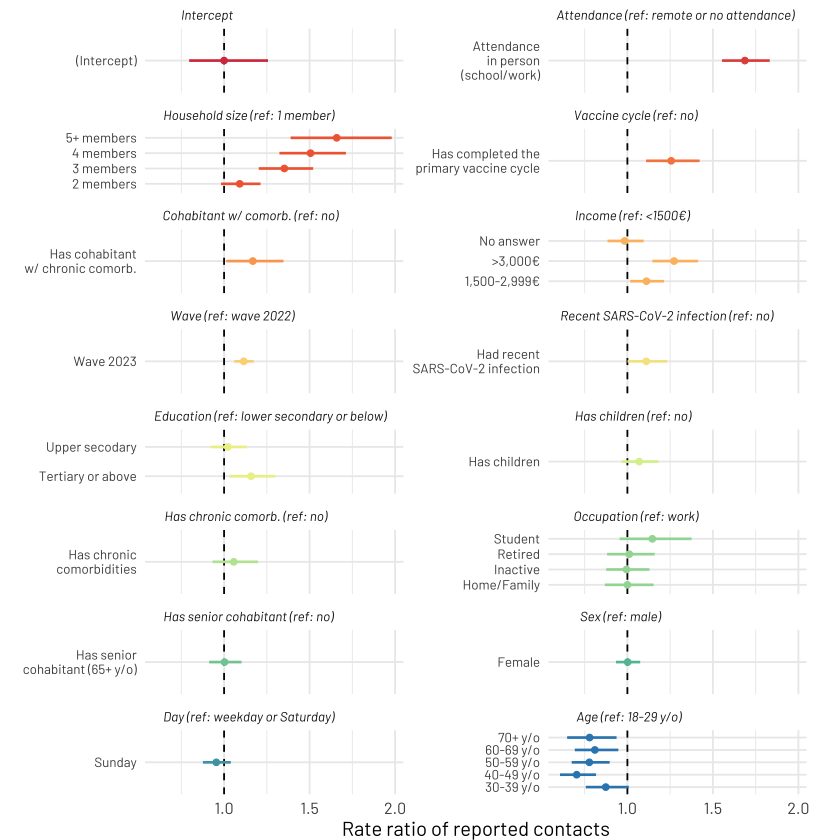

In [24]:
# Select model to plot (for ADULTS)
modelToPlot <- adults_indirect_totcont
# Plot rate ratio of reported contacts
pdf("figures_out/figure1_adults_direct_and_indirect_totcont.pdf")
res <- create_coefficient_plot(modelToPlot, group_order, group_names)
plot <- res$plot
nums <- res$tidy_results
print(plot)
dev.off()
print(plot)

In [25]:
nums

effect,component,term,estimate,std.error,statistic,p.value,contacts_risk_ratio,conf.low_ratio,conf.high_ratio,term_new,group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
fixed,cond,(Intercept),0.9845020899,0.11663888,8.440599616,3.157139e-17,1.0000000,0.7956370,1.2568545,(Intercept),Intercept
fixed,cond,wave2,0.1088917706,0.02608013,4.175277154,2.976235e-05,1.1150417,1.0594763,1.1735212,Wave 2023,Wave (ref: wave 2022)
fixed,cond,respondent_genderFemale,0.0016739158,0.03590957,0.046614756,9.628203e-01,1.0016753,0.9335985,1.0747162,Female,Sex (ref: male)
fixed,cond,age_group_1030-39 y,-0.1351950921,0.07320941,-1.846690110,6.479207e-02,0.8735455,0.7567778,1.0083299,30-39 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1040-49 y,-0.3516689500,0.07611642,-4.620145495,3.834710e-06,0.7035130,0.6060110,0.8167022,40-49 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1050-59 y,-0.2517867677,0.07258239,-3.468978878,5.224405e-04,0.7774105,0.6743215,0.8962595,50-59 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1060-69 y,-0.2110544091,0.07994922,-2.639855787,8.294131e-03,0.8097300,0.6922869,0.9470968,60-69 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1070+ y,-0.2499257638,0.09415086,-2.654524583,7.942025e-03,0.7788586,0.6476133,0.9367020,70+ y/o,Age (ref: 18-29 y/o)
fixed,cond,educationHigh school,0.0210986440,0.05276993,0.399823243,6.892867e-01,1.0213228,0.9209676,1.1326134,Upper secodary,Education (ref: lower secondary or below)


agg_record_1132146515 
                    2

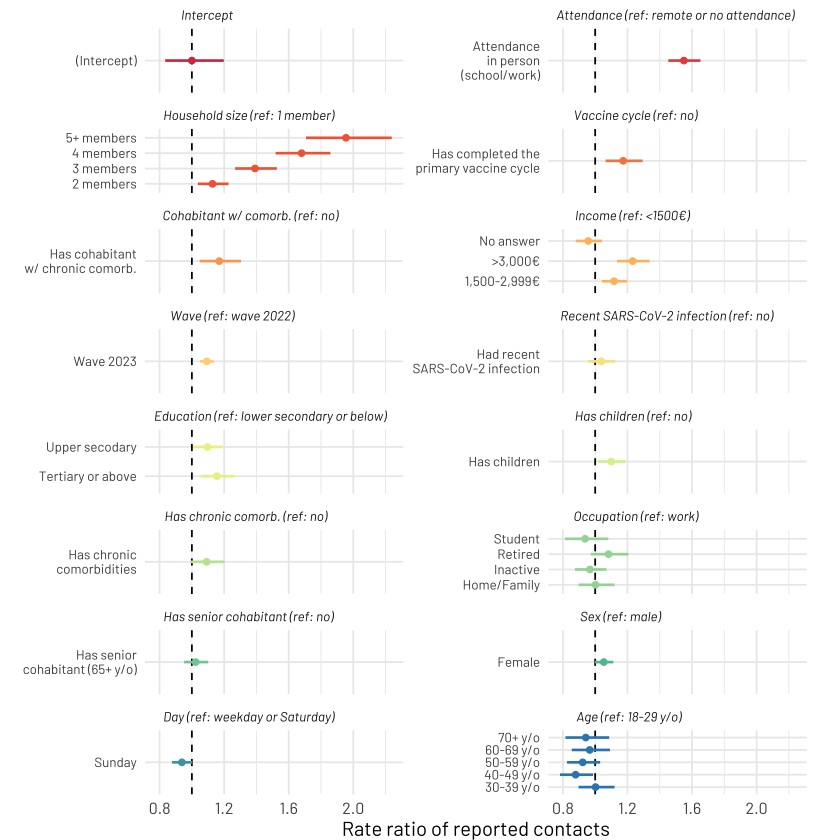

In [26]:
# Select model to plot (for ADULTS)
modelToPlot <- adults_orig_totcont
# Plot rate ratio of reported contacts
pdf("figures_out/SIfigure9_adults_direct_totcont.pdf")
res <- create_coefficient_plot(modelToPlot, group_order, group_names)
plot <- res$plot
nums <- res$tidy_results
print(plot)
dev.off()
print(plot)

In [27]:
nums

effect,component,term,estimate,std.error,statistic,p.value,contacts_risk_ratio,conf.low_ratio,conf.high_ratio,term_new,group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
fixed,cond,(Intercept),0.527349175,0.09209379,5.72621891,1.026937e-08,1.0000000,0.8348495,1.1978207,(Intercept),Intercept
fixed,cond,wave2,0.088922300,0.02045402,4.34742497,1.377452e-05,1.0929957,1.0500444,1.1377040,Wave 2023,Wave (ref: wave 2022)
fixed,cond,respondent_genderFemale,0.051806436,0.02787105,1.85879010,6.305690e-02,1.0531719,0.9971831,1.1123042,Female,Sex (ref: male)
fixed,cond,age_group_1030-39 y,0.002281353,0.05674308,0.04020497,9.679297e-01,1.0022840,0.8967886,1.1201894,30-39 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1040-49 y,-0.129445367,0.05931331,-2.18239988,2.908003e-02,0.8785826,0.7821573,0.9868953,40-49 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1050-59 y,-0.080504992,0.05656668,-1.42318759,1.546818e-01,0.9226503,0.8258223,1.0308314,50-59 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1060-69 y,-0.034483890,0.06233918,-0.55316560,5.801500e-01,0.9661039,0.8549873,1.0916616,60-69 y/o,Age (ref: 18-29 y/o)
fixed,cond,age_group_1070+ y,-0.060179502,0.07314217,-0.82277435,4.106363e-01,0.9415955,0.8158391,1.0867365,70+ y/o,Age (ref: 18-29 y/o)
fixed,cond,educationHigh school,0.091981534,0.04151933,2.21539059,2.673327e-02,1.0963446,1.0106601,1.1892935,Upper secodary,Education (ref: lower secondary or below)


## Underage respondents

In [12]:
children_indirect_totcont <- readRDS("model_out/children_indirect_totcont_glmmTMB.rds")
children_indirect_ncohabcont <- readRDS("model_out/children_indirect_ncohabcont_glmmTMB.rds")
children_orig_totcont <- readRDS("model_out/children_orig_totcont_glmmTMB.rds")
children_soft_totcont <- readRDS("model_out/children_soft_totcont_glmmTMB.rds")

In [13]:
### Get Fig1 MAIN Covariate groups' order
# Step 1: Tidy "adults_indirect_totcont" model
tidy_results <- tidy(children_indirect_totcont, effects = 'fixed')
# Step 2: Extract the intercept
intercept <- tidy_results %>% filter(term == '(Intercept)') %>% pull(estimate)
intercept_exp <- exp(intercept)
# Step 3: Exponentiate and normalize estimates, excluding the intercept
z_std <- 1.96
tidy_results <- tidy_results %>%
  mutate(
    contacts_risk_ratio = ifelse(
      term != '(Intercept)',
      exp(estimate),  # Exponentiate and divide by intercept
      1  # Set intercept to 1
    ),
    # Step 4: Compute confidence intervals
    conf.low_ratio = ifelse(
      term != '(Intercept)',
      exp(estimate - z_std * std.error),
      exp(intercept - z_std * std.error) / intercept_exp
    ),
    conf.high_ratio = ifelse(
      term != '(Intercept)',
      exp(estimate + z_std * std.error),
      exp(intercept + z_std * std.error) / intercept_exp
    )
  )

# Step 4: attach covariate-group to each covariate
group_names <- c('Intercept',
    'Wave (ref: wave 2022)',
    'Sex (ref: male)',
    'Age (ref: 6-13 y/o)',
    'Age (ref: 6-13 y/o)',
    "Parents' education (ref: lower secondary or below)",
    "Parents' education (ref: lower secondary or below)",
    "Parents' occupation (ref: working)",
    'Income (ref: <1500€)',
    'Income (ref: <1500€)',
    'Income (ref: <1500€)',
    'Attendance (ref: remote or no attend.)',
    'Enrolled in kindergarden (ref: no)',
    'Day (ref: weekday or Saturday)',
    'COVID-19 vaccine cycle (ref: no)',
    'Childhood vaccinations (ref: no)',
    'Childhood vaccinations (ref: no)',
    'Recent SARS-CoV-2 infection (ref: no)',
    'Has chronic comorb. (ref: no)',
    'Cohabitant w/ comorb. (ref: no)',
    'Has senior cohabitant (ref: no)',
    'Household size (ref: 1 member)',
    'Household size (ref: 1 member)',
    'Household size (ref: 1 member)',
    'Household size (ref: 1 member)'
    )
tidy_results$group <- group_names

group_order <- tidy_results %>%
group_by(group) %>%
summarize(avg_abs_estimate = mean(abs(contacts_risk_ratio))) %>%
arrange(desc(avg_abs_estimate)) %>%
pull(group)
group_order <- c("Intercept",group_order[group_order != "Intercept"])


In [16]:
########################################################################################
# Function to generate a list of n colors by interpolating between the provided colors #
generate_palette <- function(input_colors, n, color_names) {
  if (length(input_colors)<2) {stop("At least two colors are required to interpolate.")}
  if (length(color_names) != n) {stop("Number of color names must match the desired number of colors.")}
  # Create a color ramp palette
  color_ramp <- colorRampPalette(input_colors)
  # Generate n colors
  palette_colors <- color_ramp(n)
  # Create a named vector
  named_palette <- setNames(palette_colors, color_names)
  return(named_palette)
}
########################################################
# Define the function to create the coefficient plot   #
# Function to create the coefficient plot from a model #
create_child_coefficient_plot <- function(model, group_order, group_names) {
    # Step 1: Tidy model and filter out zero-inflation component
    tidy_results <- tidy(model, effects = 'fixed') %>%
      filter(component != 'zi')
    
    # Step 2: Extract the intercept
    intercept <- tidy_results %>% filter(term == '(Intercept)') %>% pull(estimate)
    intercept_exp <- exp(intercept)
    
    # Step 3: Exponentiate and normalize estimates, excluding the intercept
    z_std <- 1.96
    tidy_results <- tidy_results %>%
      mutate(
        contacts_risk_ratio = ifelse(
          term != '(Intercept)',
          exp(estimate),  # Exponentiate and divide by intercept
          1  # Set intercept to 1
        ),
        # Step 4: Compute confidence intervals
        conf.low_ratio = ifelse(
          term != '(Intercept)',
          exp(estimate - z_std * std.error),
          exp(intercept - z_std * std.error) / intercept_exp
        ),
        conf.high_ratio = ifelse(
          term != '(Intercept)',
          exp(estimate + z_std * std.error),
          exp(intercept + z_std * std.error) / intercept_exp
        )
      )
    
    tidy_results$term_new <- c('(Intercept)',
    'Wave 2023',
    'Female',
    '0-5 y/o',
    '14-17 y/o',
    'Upper secodary',
    'Tertiary or above',
    'Non working\nparents',
    '1,500-2,999€',
    '>3,000€',
    'No answer',
    'Attendance\nin person\n(school/work)',
    'Enrolled in\nkindergarden',
    'Sunday',
    'Completed SARS-CoV-2\nprimary cycle',
    'Completed',
    "Don't know",
    'Had recent\nSARS-CoV-2 infection',
    'Has chronic\ncomorbidities',
    'Has cohabitant\nw/ chronic comorb.',
    'Has senior\ncohabitant (65+ y/o)',
    '2 members',
    '3 members',
    '4 members',
    '5+ members'
    )
    tidy_results$group <- group_names
    # Reorder the group factor levels
    tidy_results$group <- factor(tidy_results$group, levels = group_order)

    # Using "generate_palette"
    input_colors <- brewer.pal(8, "Spectral")
    desired_number_of_colors <- length(group_order)

    # Generate the color palette
    custom_palette <- generate_palette(input_colors, desired_number_of_colors, group_order)
    
    #####################################
    #### Create the coefficient plot ####
    #####################################
    plot <- ggplot(tidy_results, aes(x = contacts_risk_ratio, y = term_new, color = group)) +
      geom_vline(xintercept = 1, linetype = "dashed") +
      geom_point() +
      geom_linerange(aes(xmin = conf.low_ratio, xmax = conf.high_ratio), linewidth = 0.75) +
      # geom_errorbarh(aes(xmin = estimate - std.error, xmax = estimate + std.error), height = 0.2) +
      theme_minimal() +
      labs(
           x = "Rate ratio of reported contacts",
           y = " ",
      ) + # Add legend title for color
      guides(color = guide_legend(title = NULL)) + # Remove legend title
      theme(
        text = element_text(family = "Barlow", size = 12), # Change the font family and size
        axis.text.y = element_text(size = 8), # Change the y-axis text size
        plot.title = element_text(hjust = 0.5), # Center the plot title
        legend.position = 'none',
        plot.margin = margin(t = 1, r = 20, b = 0, l = 0),
        strip.text = element_text(face='italic', size = 8, hjust=0.15) # Add titles for each subplot
      ) +
      scale_color_manual(values = custom_palette) + # Use the custom color palette
      facet_wrap(~ group, scales = "free_y", ncol = 2)
    list(plot = plot, tidy_results = tidy_results)
}

agg_record_244395007 
                   2

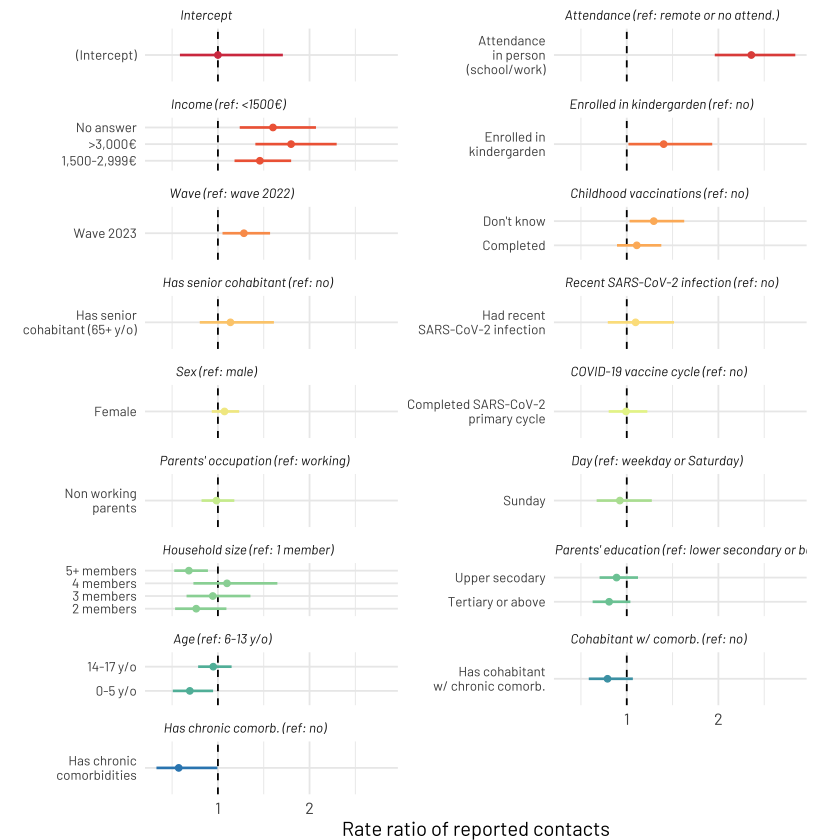

In [17]:
# Select model to plot (for ADULTS)
modelToPlot <- children_indirect_totcont
# Plot rate ratio of reported contacts
pdf("figures_out/SIfigure5_child_direct_and_indirect_totcont.pdf")
res <- create_child_coefficient_plot(modelToPlot, group_order, group_names)
plot <- res$plot
nums <- res$tidy_results
print(plot)
dev.off()
print(plot)

In [18]:
nums

effect,component,term,estimate,std.error,statistic,p.value,contacts_risk_ratio,conf.low_ratio,conf.high_ratio,term_new,group
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
fixed,cond,(Intercept),1.456052946,0.27333887,5.32691512,9.989482e-08,1.0000000,0.5852336,1.7087194,(Intercept),Intercept
fixed,cond,wave2,0.249810420,0.10247017,2.43788436,1.477350e-02,1.2837820,1.0501877,1.5693350,Wave 2023,Wave (ref: wave 2022)
fixed,cond,respondent_genderFemale,0.069434207,0.07084844,0.98003859,3.270671e-01,1.0719015,0.9329266,1.2315791,Female,Sex (ref: male)
fixed,cond,age_group_child0-5 y,-0.366029487,0.15919514,-2.29925040,2.149072e-02,0.6934824,0.5076049,0.9474255,0-5 y/o,Age (ref: 6-13 y/o)
fixed,cond,age_group_child14-17 y,-0.051973595,0.09755677,-0.53275233,5.942050e-01,0.9493539,0.7841265,1.1493972,14-17 y/o,Age (ref: 6-13 y/o)
fixed,cond,parental_educationHigh school,-0.118253596,0.11936397,-0.99069759,3.218333e-01,0.8884707,0.7031346,1.1226588,Upper secodary,Parents' education (ref: lower secondary or below)
fixed,cond,parental_educationUniversity,-0.213754914,0.12875833,-1.66012497,9.688931e-02,0.8075463,0.6274312,1.0393665,Tertiary or above,Parents' education (ref: lower secondary or below)
fixed,cond,parental_occupationOther (not working),-0.015965009,0.09225292,-0.17305695,8.626067e-01,0.9841618,0.8213707,1.1792171,Non working parents,Parents' occupation (ref: working)
fixed,cond,"income_threecat1,500-2,999 eur",0.376990159,0.10736300,3.51136005,4.458201e-04,1.4578900,1.1812328,1.7993431,"1,500-2,999€",Income (ref: <1500€)
